# Hrátky s diskrétní Fourierovou transformací: audio

*Tomáš Kalvoda, KAM FIT ČVUT, 2015*

Tento notebook slouží jako doplněk k výuce předmětu BI-VMM. Předvedeme si výpočet spektrogramu audiosignálu.

K výpočtům používáme programovací jazyk [Julia](www.julialang.org).

## 1. Úvodní příklad

### Import dat

Abychom mohli pracovat se zvukovými daty, musíme je nejprve importovat. K tomu účelu využijeme balíček [WAV.jl](https://github.com/dancasimiro/WAV.jl). Pokud nemáte tento balíček nainstalován, stačí v interaktivní příkazové řádce Julia (REPL) vydat příkaz `Pkg.add("WAV")`.

In [31]:
# balíček pro práci s WAV soubory
using WAV

Začněme s jednoduchou ukázkou. Příkaz `wavread` načte ze zadaného WAV souboru vzorky, vzorkovací frekvenci a počet bitů použitých na kódování vzorků. Ve výchozím nastavení jsou hodnoty vzorků v rozmezí od $-1.0$ do $1.0$.

In [32]:
# načtení dat
y, fs, nbits = wavread("violin.wav")
# info
println("Frekvence: $fs")
println("Bitů: $nbits")
println("Prvních deset vzorků:")
println(y[1:10])

Frekvence: 44100
Bitů: 16
Prvních deset vzorků:
[0.0005493331705679495,-0.0003662221137119663,-0.0010681478316599017,-0.0008545182653279214,0.0003967406231879635,-9.155552842799158e-5,-0.0007324442274239326,-0.0006103701895199438,-0.0006103701895199438,-0.0004272591326639607]


Záznam si můžeme přehrát, stačí zavolat `wavplay` s vzorky a frekvencí.

In [33]:
wavplay(y,fs)

### Generování grafů

Pojďme se nejprve podrobněji podívat na data v souboru, který jsme v předchozí části načetli. K tomu použijeme velmi jednoduchý balíček na generování grafů [Winston](https://github.com/nolta/Winston.jl).

In [34]:
# balíček pro generování grafů
using Winston

Vykresleme celý záznam.

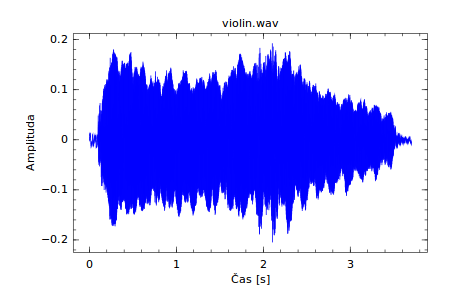

In [35]:
# vzorkovací frekvence je fs, časový krok mezi vzorky
# proto je 1/fs sekund.
plot(Float64[k*1/fs for k = 1:length(y)], y, "b")
xlabel("Čas [s]")
ylabel("Amplituda")
title("violin.wav")

Nenechte se zmást. Předchozí graf sice vypadá jako skvrna, ale skutečně jde o záznam jistých oscilací. Podívejme se na kratší časový interval.

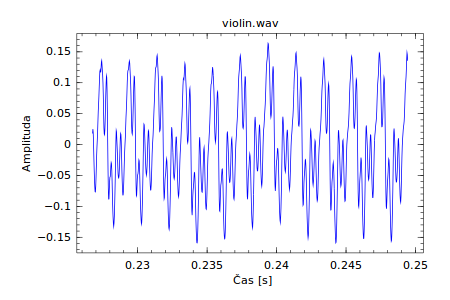

In [36]:
indmin = 10000
indmax = 11000
plot(Float64[k*1/fs for k = indmin:indmax], y[indmin:indmax], "b")
xlabel("Čas [s]")
ylabel("Amplituda")
title("violin.wav")

### Rychlá Fourierova transformace (FFT)

Abych prozkoumali jaké frekvence jsou v signálu obsaženy, použijeme diskrétní Fourieorovu transformaci (DFT). Pro připomenutí uvádíme definiční vztah z přednášky (bez normalizačního faktoru):

$$ \hat x_k = \sum_{j=0}^{N-1} x_k e^{-2i\pi kj/N}\,, \quad k = 0,1,\ldots,N-1\,. $$

Vstupnímu vektoru $(x_0,x_1,\ldots,x_{N-1}) \in \mathbb{C}^N$ délky $N$ je tímto předpisem přiřazen vektor $(\hat x_0, \hat x_1,\ldots,\hat x_{N-1})\in\mathbb{C}^N$. Poznamenejme, že jsme vynechali normalizační člen $\frac{1}{\sqrt{N}}$, na výsledky v tomto notebooku nemá žádný vliv. Naivní implementací DFT by tedy bylo prosté přepsání tohoto vztahu:


In [39]:
# naivní implementace DFT
function naiveDFT(data::Vector{Complex64})
    # délka vektoru
    n = length(data)
    # alokace paměti pro uložení výsledku
    ft = Array(Complex64, (n,1))
    # napočtení složek výsledného vektoru
    for k in 0:n-1
        ft[k+1] = sum(j->data[j+1]*exp(-2im*pi*k*j/n), 0:n-1)
    end
    return ft
end
# metoda pro reálný vektor
naiveDFT(data::Vector{Float64}) = naiveDFT(convert(Vector{Complex64}, data))

naiveDFT (generic function with 2 methods)

Na přednášce jsme si ukázali Cooley-Tukey algoritmus, který počítá DFT na vektorech, jejichž délka je mocninou dvou. Protože jeho složitost (vzhledem k délce vstupu) je $\mathcal{O}(N\log N)$, na rozdíl od složitosti $\mathcal{O}(N^2)$ naivní implementace, mluvíme o něm jako o rychlé Fourierově transformaci (FFT).

In [40]:
# FFT, rekurzivní Cooley-Tukey algoritmus
function myFFT(data::Vector{Complex64})
    # délka vektoru a poloviční délka vektoru
    n, halfn = length(data), div(length(data), 2)
    if n == 2
        # DFT dvousložkového vektoru
        return Complex64[data[1] + data[2], data[1] + exp(-pi*1im)*data[2]]
    else
        # "decimace", N.B. v původním vzorci indexujeme
        # od 0, Julia indexuje od 1.
        even = myFFT(data[1:2:n-1])
        odd = myFFT(data[2:2:n])
        return Complex64[ even[mod(k,halfn)+1] + exp(-2im*pi*k/n)*odd[mod(k,halfn)+1] for k = 0:n-1]
    end
end
# metoda pro reálný vektor
myFFT(data::Vector{Float64}) = myFFT(convert(Vector{Complex64}, data))

myFFT (generic function with 2 methods)

Julia má samozřejmě FFT k dispozici i samostatně pomocí funkce `fft`. Dle dostupných informací (zdrojový kód [julia/base/fftw.jl](https://github.com/JuliaLang/julia/blob/master/base/fftw.jl)) Julia využívá knihovnu [FFTW](http://www.fftw.org/). Tato knihovna nabízí i další zobecnění Cooley-Tukey algoritmu i na vektory libovolné délky.

Porovnejme rychlosti (čas) a výsledky těchto tří funkcí (`naiveDFT`, `myFFT` a `fft`) na náhodných datech. Upozorňujeme, že je vždy potřeba funkce invokovat aspoň dvakrát, při prvním volání se kompilují (Julia využívá JIT).

In [10]:
# náhodný vektor dély 1024
data = rand(1024);
println("naiveDFT:")
@time naivedata = naiveDFT(data);
println("myFFT:")
@time mydata = myFFT(data);
println("fft:")
@time jdata = fft(data);

naiveDFT:
elapsed time: 0.856823375 seconds (184632708 bytes allocated, 27.69% gc time)
myFFT:
elapsed time: 0.0028501 seconds (293840 bytes allocated)
fft:
elapsed time: 0.000118172 seconds (18376 bytes allocated)


Zkontrolujme, že v rámci chyb při aritmetických operacích v konečné přesnosti jsme získali stejné výsledky.

In [11]:
println("Maximální absolutní rozdíly ve složkách výstupu:")
println("Naivní vs. naše FFT: ", maximum(abs(naivedata - mydata)))
println("Naše FFT vs. FFTW ", maximum(abs(mydata - jdata)))

Maximální absolutní rozdíly ve složkách výstupu:
Naivní vs. naše FFT: 1.7166138e-5
Naše FFT vs. FFTW 1.7567573479482235e-5


In [33]:
kstart = 3
klen = 10
telapsed = Array(Float64,(klen,4))
for k in kstart:kstart+klen-1
    data = rand(2^k)
    telapsed[k-kstart+1,:] = [2^k,
        mean([@elapsed(naiveDFT(data)) for j in 1:10]), 
        mean([@elapsed(myFFT(data)) for j in 1:10]),
        mean([@elapsed(fft(data)) for j in 1:10])
    ]
end
println("Done!")

Done!


Následující tabulka porovnává průměrné doby (v sekundách) běhu tří výše zmíněných funkcí na vektorech délky `n`.

In [34]:
using DataFrames
DataFrame(n=telapsed[:,1], dft=telapsed[:,2], myfft=telapsed[:,3], fftw=telapsed[:,4])

,n,dft,myfft,fftw
1,8.0,4.8609599999999996e-5,1.1733300000000002e-5,1.8074900000000002e-5
2,16.0,0.0001754702,2.6232700000000004e-5,1.5476999999999998e-5
3,32.0,0.0006426546000000001,5.88345e-5,1.49742e-5
4,64.0,0.0024285328,0.0001307713,3.229480000000001e-5
5,128.0,0.0142892868,0.0002831938,6.137659999999999e-5
6,256.0,0.0498765507,0.0006123432000000001,3.86086e-5
7,512.0,0.2021802144,0.007793821300000001,4.1765300000000005e-5
8,1024.0,0.8459697095000001,0.0028108735000000004,5.2660399999999995e-5
9,2048.0,3.5364628815000003,0.0060639004,8.47875e-5
10,4096.0,14.2383573074,0.012891589,0.0001259385


### Spektrogram

Vraťme se k významu samotné diskrétní Fourierovy transformace. Stručně lze říci, že hodnota její složky, $\hat x_n$ udává, jakou mírou do vstupního signálu $(x_k)_{k=0}^{N-1}$ přispívá harmonická oscilace s frekvencí $n/T$, kde $T$ je celková délka vstupního signálu $(x_k)_{k=0}^{N-1}$ (v sekundách). Tedy $T = N/f_s$, kde $f_s$ je vzorkovací frekvence. Frekvence je pak dána v Herzech. Například pro zpracování záznamu řeši se často volí délka okna 25 ms a používá se překryv 10 ms.

V této sekci sestrojíme tak zvaný spektrogram zvukového záznamu. Jedná se o poměrně přímočarý proces. Vstupní signál rozdělíme na kratší úseky, tzv. "okna", která se překrývají. Dále vypočteme DFT každého okna. Do grafu pak na vodorovnou osu vynášíme čas a na svislou osu frekvenci. Bod s danou souřadnicí pak vybarvíme podle toho, jaká je hodnota Fourierovy transformace (typicky dle kvadrátu absolutní hodnoty, intenzity).

Před provedením DFT se záznam v okně ještě často upravuje přenásobením tzv. [okénkovou funkcí](http://en.wikipedia.org/wiki/Window_function). My budeme nejčastěji používat Hannovu funkci. Vliv této úpravy signálu na výsledný spektrogram si ukážeme o několik řádek níže.

In [41]:
# Hannova okénková funkce
function hanning(n::Integer)
    [0.5*(1 - cos(2*pi*k/(n-1))) for k=0:(n-1)]
end
# Pravoúhla okénková funkce
function rectangular(n::Integer)
    ones(Float64,n)
end;

Graf pro lepší představu.

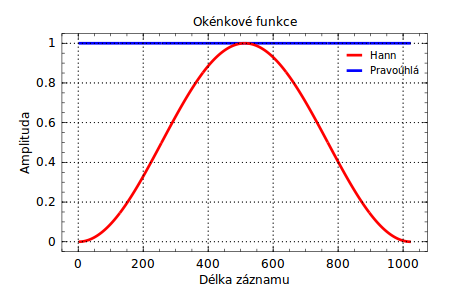

In [42]:
p = FramedPlot(
    title="Okénkové funkce",
    xlabel="Délka záznamu",
    ylabel="Amplituda"
)
setattr(p.frame, draw_grid=true)
fighann = Curve(1:1024, hanning(1024), color="red", linewidth=7)
setattr(fighann, label="Hann")
figrect = Curve(1:1024, rectangular(1024), color="blue", linewidth=7)
setattr(figrect, label="Pravoúhlá")
leg = Legend(.8, .9, {fighann, figrect})
add(p, figrect, fighann, leg)

 Vykreslování provedeme pomocí následující funkce.

In [43]:
function spec(data::Vector{Float64}, # vstupní signál
    freq::Real; # vzorkovací frekvence
    wlen::Float64=0.025, overlap::Float64=0.01, # nepovinná délka okna, překryv (v sekundách)
    maxfreq=pi*freq, logscale=true, wfunc=hanning, # ořez frekvence, měřítko intenzity, okénková funkce
    mytitle="Spektrogram" # titulek grafu
    )
    # délka záznamu (počet vzorků
    n = length(data)
    # délka okénka (počet vzorků)
    wn = round(Int64, wlen*freq)
    # základní frekvence
    bfreq = freq/wn
    # délka překryvu (počet vzorků)
    overlapn = round(Int64, overlap*freq)
    # předpočítání Hanningovy funkce
    wdat = wfunc(wn)
    # pole kam budeme zapisovat výsledky
    spectrum = Array(Complex64, (wn,0))
    # průběžný index
    k = 0
    while k + wn < n
        # aplikace Hanningovy funkce
        spectrum = hcat(spectrum, fft(data[k+1:k+wn] .* wdat))
        k += wn - overlapn
    end
    if logscale
        imgdata = map(x -> log(1+abs(x)^2), spectrum)
    else
        imgdata = map(x -> abs(x)^2, spectrum)
    end
    imagesc((0,n/freq), (maxfreq,0), imgdata[1:floor(Int64,maxfreq/bfreq),:])
    ylabel("Frekvence [Hz]")
    xlabel("Čas [s]")
    title(mytitle)
end

spec (generic function with 1 method)

Spektrogram záznamu houslí, okénková funkce Hannova, okénko má délku 25ms a překryv 10ms.

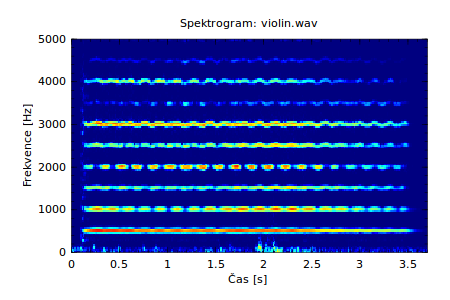

In [44]:
spec(y[:,1], fs, maxfreq=5000, mytitle="Spektrogram: violin.wav")

Spektrogram záznamu houslí, okénková funkce pravoúhlá, okénko má délku 25ms a překryv 10ms.

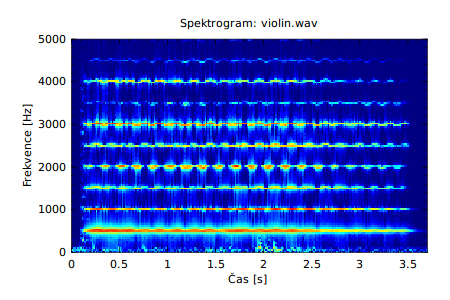

In [28]:
spec(y[:,1], fs, maxfreq=5000, mytitle="Spektrogram: violin.wav", wfunc=rectangular)

Pozorujeme, že okénková funkce má vliv na rozlišení, rozmazání, spektrogramu.

## 2. Generování tónu

Nyní se na problém podívejme z druhé strany. Naopak vygenerujme signál, přehrajme ho a podívejme se jak dopadne jeho spektrogram. Zadefinujme si nejprve frekvence standardního ladění šestistrunné kytary.

In [45]:
gtuning = {
    :e4 => 329.63,
    :b3 => 246.94,
    :g3 => 196.00,
    :d3 => 146.83,
    :a2 => 110.00,
    :e2 => 82.41
}

Dict{Any,Any} with 6 entries:
  :b3 => 246.94
  :d3 => 146.83
  :e2 => 82.41
  :e4 => 329.63
  :a2 => 110.0
  :g3 => 196.0

Následující funkce vygeneruje harmonickou oscilaci s předepsanou frekvencí `freq`, vzorkovací frekvencí `sfreq` a délkou signálu `duration`. Frekvence je opět udávána v Herzech a čas v sekundách.

In [46]:
function sinwave(freq::Float64, sfreq::Real, duration::Float64)
    n = floor(Int64,duration*sfreq)
    return Float64[ sin(2*pi*freq * k/sfreq) for k in 1:n]
end

sinwave (generic function with 1 method)

Například:

In [47]:
fs = 44100
y = sinwave(gtuning[:e4], fs, 3.0);

Graf tohoto záznamu dává skutečně očekávanou sinusovku.

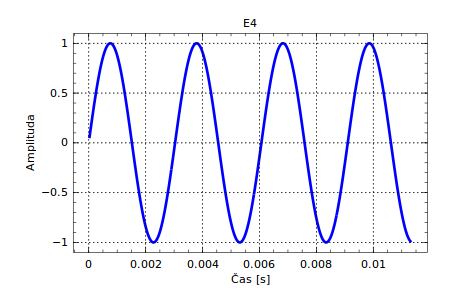

In [48]:
p = FramedPlot(
    title="E4",
    xlabel="Čas [s]",
    ylabel="Amplituda"
)
setattr(p.frame, draw_grid=true)
add(p, Curve(Float64[k*1/fs for k = 1:500], y[1:500], color="blue", linewidth=7))

Můžeme si tento signál i přehrát!

In [49]:
wavplay(y,fs)

Ve spektrogramu očekáváme jednu frekvenci.

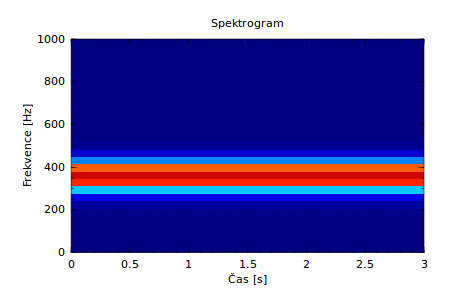

In [61]:
spec(y, fs, maxfreq=1000, wlen=0.03, overlap=0.01)

Všechny tóny od nejvyššího k nejnižšímu.

In [62]:
wave = vcat(
    sinwave(gtuning[:e4], fs, 2.0),
    sinwave(gtuning[:b3], fs, 2.0),
    sinwave(gtuning[:g3], fs, 2.0),
    sinwave(gtuning[:d3], fs, 2.0),
    sinwave(gtuning[:a2], fs, 2.0),
    sinwave(gtuning[:e2], fs, 2.0)
    );
wavplay(wave, fs)

Spektrogram tohoto záznamu:

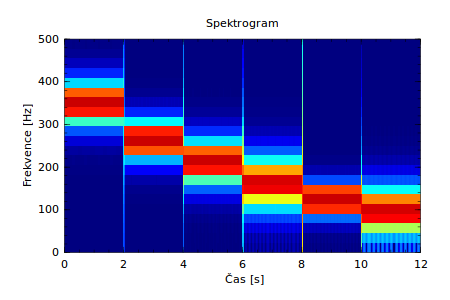

In [63]:
spec(wave, fs, maxfreq=500, wlen=0.045, overlap=0.01)

Následující pomocná funkce pouze sestaví superpozici více signálu a výsledek normalizuje na jedničku (ve smyslu absolutní hodnoty vzorku).

In [64]:
function normalizesum(args...)
    s = +(args...)
    m = maximum(abs(s))
    return 1/m .* s
end

normalizesum (generic function with 1 method)

Sestavme aproximaci 'zubového' signálu, jehož fourierovu řadu jsme počítali na přednášce. Za tím účelem použijeme šest harmonických oscilací.

In [65]:
saw = normalizesum(
    2*sinwave(gtuning[:e4], fs, 3.0),
    -1*sinwave(2*gtuning[:e4], fs, 3.0),
    2/3 * sinwave(3*gtuning[:e4], fs, 3.0),
    -2/4 * sinwave(4*gtuning[:e4], fs, 3.0),
    +2/5 * sinwave(5*gtuning[:e4], fs, 3.0),
    -2/6 * sinwave(6*gtuning[:e4], fs, 3.0),
);

Graf (z letáku).

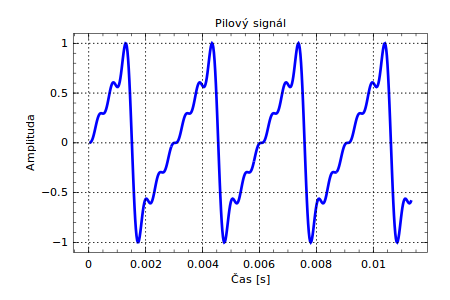

In [14]:
p = FramedPlot(
title="Pilový signál",
    xlabel="Čas [s]",
    ylabel="Amplituda"
)
setattr(p.frame, draw_grid=true)
add(p, Curve(Float64[k*1/fs for k = 1:500], saw[1:500], color="blue", linewidth=7))

Jak tento signál zní?

In [18]:
wavplay(saw, fs)

Spektrogram:

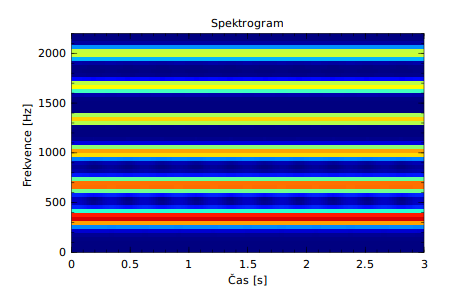

In [63]:
spec(saw, fs, maxfreq=2200)

## 3. Kytara

Pro zajímavost se podívejme na několik zvukových záznamů elektrické kytary. Nejprve prázdné struny.

In [66]:
y, fs, nbits = wavread("guitar.wav");
println("Frekvence: $fs")
println("Bitů: $nbits")

Frekvence: 44100
Bitů: 16


Přehrání záznamu.

In [67]:
wavplay(y,fs)

Spektrogram.

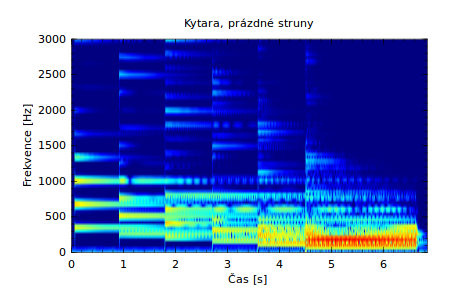

In [69]:
spec(y[:,1], fs, maxfreq=3000, mytitle="Kytara, prázdné struny")

Podívejme se na menší výřez.

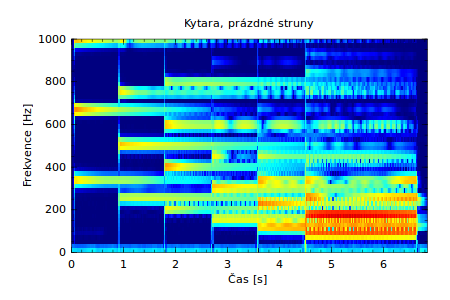

In [72]:
spec(y[:,1], fs, maxfreq=1000, mytitle="Kytara, prázdné struny", wlen=0.05, overlap=0.025)

Nyní akord G.

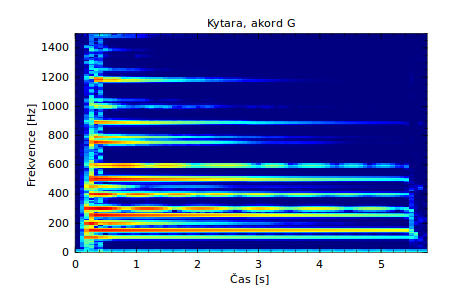

In [77]:
y, fs, nbits = wavread("guitar_g.wav");
wavplay(y,fs)
spec(y[:,1], fs, maxfreq=1500, mytitle="Kytara, akord G", wlen=0.1, overlap=0.025)

Akord G a A s kvákadlem.

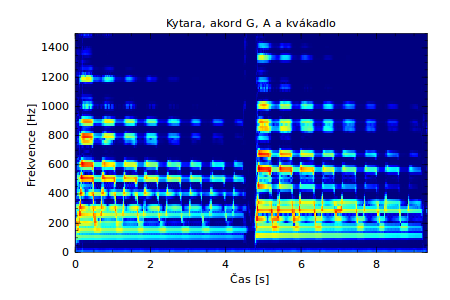

In [79]:
y, fs, nbits = wavread("guitar_gaw.wav");
wavplay(y,fs)
spec(y[:,1], fs, maxfreq=1500, mytitle="Kytara, akord G, A a kvákadlo", wlen=0.06, overlap=0.03)

Riff z 'For whom the bell tolls' od Metallica.

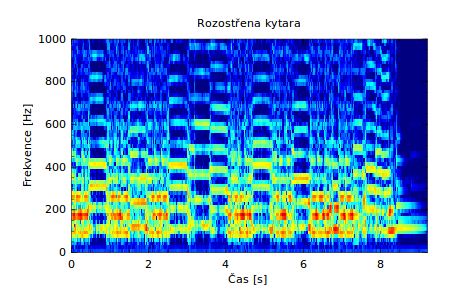

In [81]:
y, fs, nbits = wavread("guitar_m.wav");
wavplay(y,fs)
spec(y[:,1], fs, maxfreq=1000, mytitle="Rozostřena kytara", wlen=0.06, overlap=0.03)